# Mean-Shift Clustering and Segmentation

In the first part of this task you will implement the *mean-shift* clustering algorithm in a general way (not specifically for anything to do with images, just simply for n-dimensional data points).

Then you will apply mean-shift for image segmentation, by clustering data points that represent pixels (e.g. the colors).

In [46]:
%%html
<!-- Add heading numbers -->
<style>
body {counter-reset: section;}
h2:before {counter-increment: section;
           content: counter(section) " ";}
</style>

In [1]:
# Some imports
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import time
import imageio
from mpl_toolkits.mplot3d import Axes3D
import cv2
import os


## Recap from the lecture
The *mean-shift* algorithm clusters an $n$-dimensional data set (i.e., each data point is described by a feature vector of $n$ values) by associating each point with a peak in the estimated probability density of the dataset's distribution. Points associated with the "same" peak (up to some small threshold) become members of the same cluster.

For each point, mean-shift finds the associated peak by first defining a spherical window of radius $r$ centered on that point, and computing the **mean** of the points that lie within the window. The algorithm then **shifts** the window to be centered on that mean and repeats these steps until convergence, i.e., until the shift is smaller than a specified threshold (set this as 0.1). At each iteration the window shifts to a more densely populated portion of the data set until a peak is reached, where the data is approximately equally distributed in the window.

## Finding a peak from a query point
Implement the peak searching process as the function `find_peak(data, query, radius)` where

 * `data` is a $p \times n$ matrix containing $p$ data points; each point is defined by an $n$-dimensional row vector of feature values
 * `query` is the $n$-dimensional starting point from which we wish to compute a density peak
 * `radius` is the search window radius.

Return the peak as an $n$-dimensional vector.

**Hints:** You can use `np.linalg.norm` to compute the Euclidean norm of a vector. You can also index NumPy arrays with Boolean arrays, e.g. to select only rows that fulfil some criterion.

In [2]:
def find_peak(data, query, radius):
    # YOUR CODE HERE
    #calculate the center of mass (mean)
    mask = np.zeros(len(data), dtype=bool)
    for d in data:
        if np.linalg.norm(d - query) <= radius:
            # window = np.vstack((window, d))
            mask[np.where(data == d)[0]] = True
    window = data[mask]
    if len(window) > 1:
        mean = np.mean(window, axis=0)
    else:
        mean = query #case where window only contains the query point itself, then the mean is itself
    #find peak
    if np.linalg.norm(mean - query) >= 0.1:
        find_peak(data, mean, radius)
    return mean, mask

You can use the synthetic dataset `gaussian_mixture_samples_3d.csv` to test your implementation. The data points in this file are 2000 samples from two 3D Gaussian distributions. The following plots only show the projection on the XY plane.

<IPython.core.display.Javascript object>


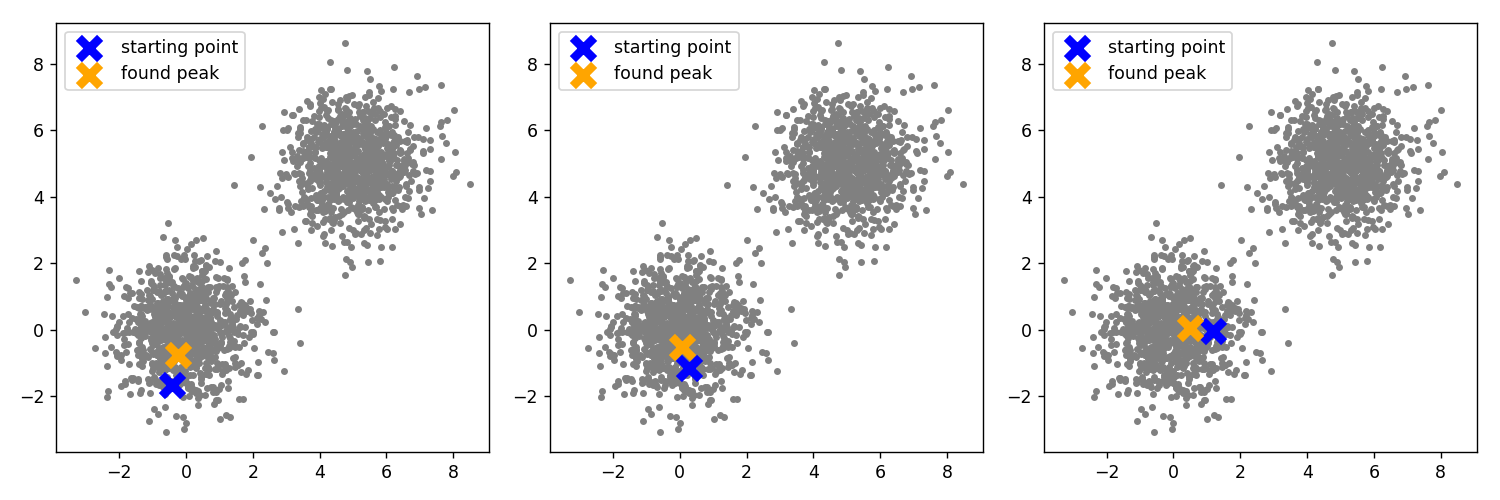

Found peak [-0.23215644 -0.76906531  0.03262443]
Found peak [ 0.06321818 -0.50363535  0.55785826]
Found peak [0.48351141 0.04833702 0.17270735]


In [3]:
data = np.genfromtxt(f'gaussian_mixture_samples_3d.csv', delimiter=',')
point_ids = [0, 5, 1500]
radius = 2

fig, axes = plt.subplots(1, len(point_ids), figsize=(12,4))
for query, ax in zip(data, axes):
    peak, _ = find_peak(data, query, radius)
    print('Found peak', peak)
    ax.scatter(data[:, 0], data[:, 1], marker='.', color='gray')
    ax.scatter(query[0], query[1], s=150, linewidth=5,
               color='blue', marker='x', label='starting point')
    ax.scatter(peak[0], peak[1], color='orange', marker='x',
               s=150, linewidth=5, label='found peak')
    ax.legend()
fig.tight_layout()

## Clustering all points
Implement `mean_shift(data, radius)`, which calls `find_peak` for each point and then assigns a label to each point according to its peak.
`mean_shift` should return two arrays: `peaks` and `labels`.

  * `peaks` is a matrix with $k$ rows, storing the found density peaks, where $k$ is the data-dependent number of clusters found. 
  * `labels` is a $p$-sized vector that has an entry for each data point, storing its associated cluster label (an integer)

Similar peaks within a distance of `radius`/2 should be considered the same and should be merged after each call to `find_peak`. More specifically, if the peak computed for a data point already exists in `peaks` (according to the distance threshold), then discard the newly computed peak and give the label of the already existing peak to the considered data point.

In [4]:
def mean_shift(data, radius):
    labels = np.full(len(data), fill_value=-1, dtype=int)
    
    # YOUR CODE HERE
    peaks = np.array([0, 0, 0])
    count = 0
    for i in range(len(data)):
        new_peak = True
        peak, _ = find_peak(data, data[i], radius)
        for j in range(len(peaks)):
            if np.linalg.norm(peak - peaks[j]) <= 0.1:
                # peaks[j] = peak
                labels[i] = j
                new_peak = False
                # print(f"point {i}: {data[i]} old peak {j}: {peaks[j]}")
                break
        if new_peak:
            # print(f"point {i}: {data[i]} new peak {count + 1}: {peak}")
            peaks = np.vstack((peaks, peak))
            count += 1
            peaks[count] = peak
            labels[i] = count
    return peaks, labels

Now check the result of your implementation. The found peaks (cluster centers) are shown as black X marks. You can rotate the interactive 3D plots with the mouse (but it may be somewhat slow).

<IPython.core.display.Javascript object>


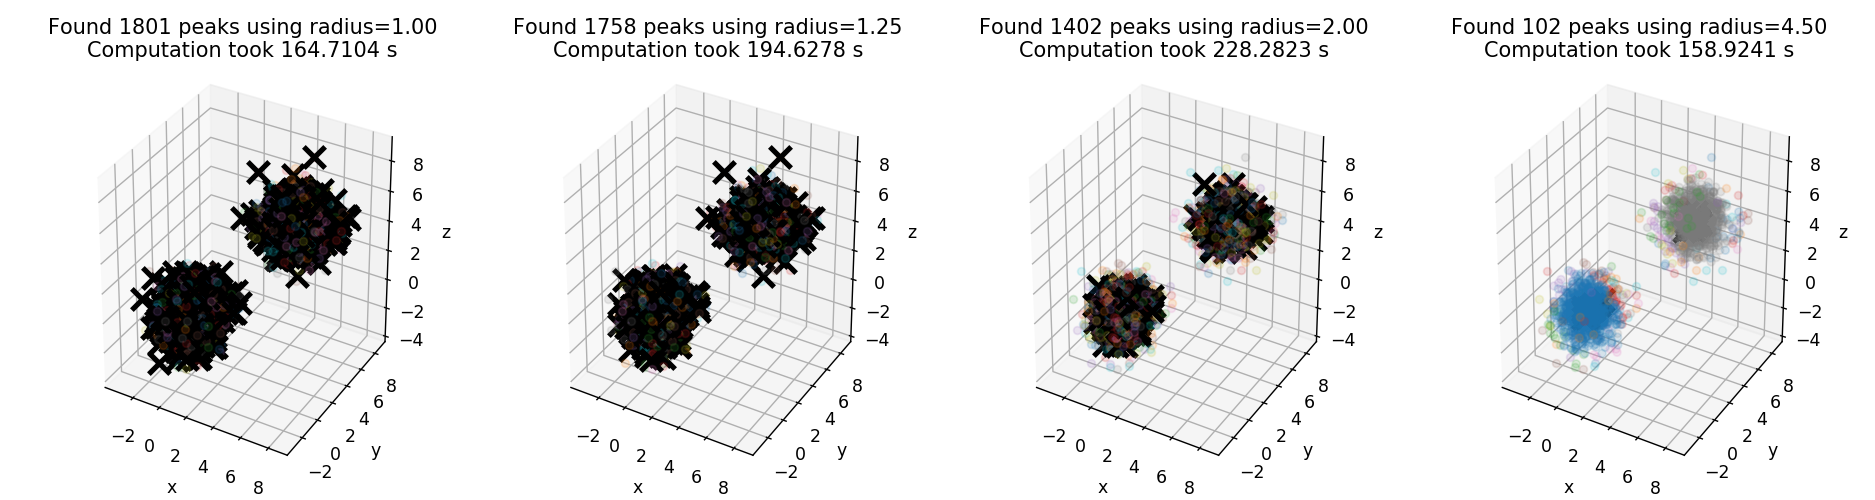

In [5]:
def plot_3d_clusters(ax, data, labels, peaks, 
                     peak_colors=None, colors=None, axis_names='xyz'):
    """Plots a set of point clusters in 3D, each with different color."""

    def luv2rgb(color):
        expanded = color[np.newaxis, np.newaxis]
        rgb = cv2.cvtColor(expanded.astype(np.uint8), cv2.COLOR_LUV2RGB)
        return rgb[0,0]/255
      
    if peak_colors is None:
        peak_colors = peaks
    
    for label in range(len(peaks)):
        if colors=='rgb':
            cluster_color = color = peak_colors[label]/255
        elif colors=='luv':
            cluster_color = luv2rgb(peak_colors[label])
        else:
            cluster_color=None

        cluster = data[labels==label]
        ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2],
                   alpha=0.15, color=cluster_color)
        ax.scatter(peaks[label, 0], peaks[label, 1], peaks[label, 2], 
                   color='black', marker='x', s=150, linewidth=3)

    ax.set_xlabel(axis_names[0])
    ax.set_ylabel(axis_names[1])
    ax.set_zlabel(axis_names[2])

data = np.genfromtxt(f'gaussian_mixture_samples_3d.csv', delimiter=',')
radii = [1, 1.25, 2, 4.5]
fig, axes = plt.subplots(
    1, len(radii), figsize=(15,4), subplot_kw={'projection': '3d'})

for radius, ax in zip(radii, axes): 
    start_time = time.time()
    peaks, labels = mean_shift(data, radius)
    plot_3d_clusters(ax, data, labels, peaks)
    duration = time.time()-start_time
    ax.set_title(
        f'Found {len(peaks)} peaks using radius={radius:.2f}\n'
        f'Computation took {duration:.4f} s\n')
    
fig.tight_layout()

## Speedups

As described so far, the mean-shift algorithm is too slow to be used for image segmentation where each data point corresponds to a pixel. Therefore, you should incorporate the following two speedups from the lecture into your implementation. 

**First speedup**: upon finding a new peak, associate each data point within `radius` distance from that peak with the cluster defined by that peak. This speedup is known as the *“basin of attraction”* and is based on the intuition that points within one window size distance from the peak will, with high probability, converge to that peak. 

Call the new function `mean_shift_opt`.

In [6]:
def mean_shift_opt(data, radius):
    labels = np.full(len(data), fill_value=-1, dtype=int)
    
    # YOUR CODE HERE
    peaks = np.array([])
    count = -1
    for i in range(len(data)):
        # print(f"processing point {i}")
        if labels[i] != -1:
            continue
        new_peak = True
        peak, mask = find_peak(data, data[i], radius)
        for j in range(len(peaks)):
            if np.linalg.norm(peak - peaks[j]) <= 0.1:
                peaks[j] = peak
                labels[mask] = j
                new_peak = False
                # print(f"point {i}: {data[i]} old peak {j}: {peaks[j]}")
                break
        if new_peak:
            # print(f"point {i}: {data[i]} new peak {count + 1}: {peak}")
            if count == -1: #Append first peak
                peaks = np.append(peaks, peak, axis=0)[np.newaxis]
                labels[mask] = count
                count += 1
            else:
                peaks = np.append(peaks, peak[np.newaxis], axis=0)
                count += 1
                peaks[count] = peak
                labels[mask] = count
    return peaks, labels

Now run the code to check the result.

<IPython.core.display.Javascript object>


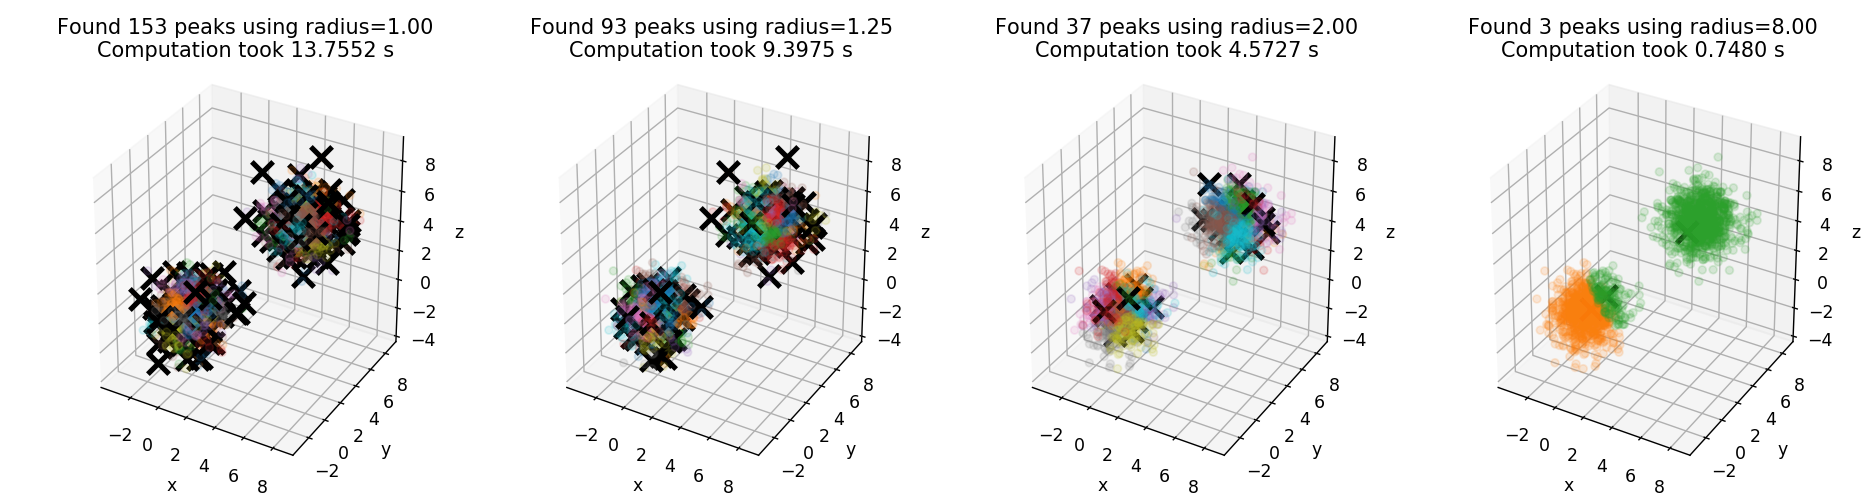

In [7]:
data = np.genfromtxt(f'gaussian_mixture_samples_3d.csv', delimiter=',')
radii = [1, 1.25, 2, 8]
fig, axes = plt.subplots(
    1, len(radii), figsize=(15,4), subplot_kw={'projection': '3d'})

for radius, ax in zip(radii, axes): 
    start_time = time.time()
    peaks, labels = mean_shift_opt(data, radius)
    plot_3d_clusters(ax, data, labels, peaks)
    duration = time.time()-start_time
    ax.set_title(
        f'Found {len(peaks)} peaks using radius={radius:.2f}\n'
        f'Computation took {duration:.4f} s\n')
    
fig.tight_layout()

The **second speedup** is based on a similar principle: Associate points within a distance $\mathtt{radius}/c$ of the search path with the converged peak ($c$ is some constant value). Use $c = 3$ for this assignment.

To realize this speedup, you will need to modify `find_peak` into `find_peak_opt`, which returns two values: `peak` and `is_near_search_path`. The latter should be a Boolean output vector of length $p$ (number of data points) containing `True` for each point that we encountered within a distance $\mathtt{radius}/c$ on our search path, and `False` for the others. Then use this boolean vector in a new version of `mean_shift_opt`, called `mean_shift_opt2` to do the label assignments accordingly.

<IPython.core.display.Javascript object>


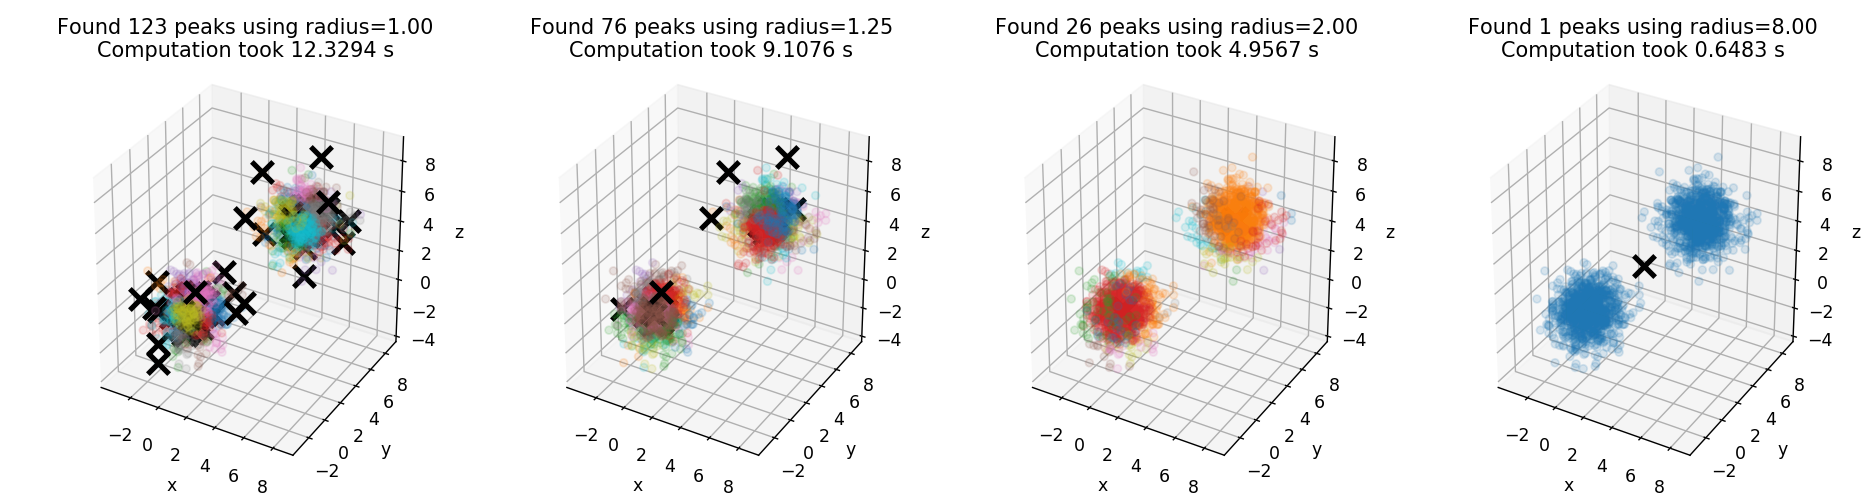

In [12]:
def find_peak_opt(data, query, radius, c=3):
    is_near_search_path = np.zeros(len(data), dtype=bool)
    
    # YOUR CODE HERE
    path_radius = radius/c
    while True:
        # print("find peak:")
        # print(query)
        #Find points within the window
        for d in data:
            if np.linalg.norm(d - query) <= radius:
                # window = np.vstack((window, d))
                is_near_search_path[np.where(data == d)[0]] = True
        window = data[is_near_search_path]
        if len(window) > 1:
            mean = np.mean(window, axis=0)
        else:
            mean = query  # case where window only contains the query point itself, then the mean is itself
        #check if peak has been found
        if np.linalg.norm(mean - query) <= 0.1:
            return mean, is_near_search_path
            break
        else:
            # Find points within the area along the path and mark them as checked
            for d in data:
                if np.linalg.norm(d - mean) <= path_radius:
                    # window = np.vstack((window, d))
                    is_near_search_path[np.where(data == d)[0]] = True
            query = mean

def mean_shift_opt2(data, radius):
    labels = np.full(len(data), fill_value=-1, dtype=int)
    
    # YOUR CODE HERE
    peaks = np.array([])
    count = -1
    for i in range(len(data)):
        if labels[i] != -1:
            continue
        new_peak = True
        data_i = data[i]
        # print("mean shift:")
        # print(data[i])
        peak, mask = find_peak_opt(data, data[i], radius)
        for j in range(len(peaks)):
            if np.linalg.norm(peak - peaks[j]) <= 0.1:
                peaks[j] = peak
                labels[mask] = j
                new_peak = False
                # print(f"point {i}: {data[i]} old peak {j}: {peaks[j]}")
                break
        if new_peak:
            # print(f"point {i}: {data[i]} new peak {count + 1}: {peak}")

            if count == -1: #Append first peak
                peaks = np.append(peaks, peak, axis=0)[np.newaxis]
                labels[mask] = count
                count += 1
            else:
                peaks = np.append(peaks, peak[np.newaxis], axis=0)
                count += 1
                peaks[count] = peak
                labels[mask] = count
    return peaks, labels

data = np.genfromtxt(f'gaussian_mixture_samples_3d.csv', delimiter=',')
radii = [1, 1.25, 2, 8]
fig, axes = plt.subplots(
    1, len(radii), figsize=(15,4), subplot_kw={'projection': '3d'})

for radius, ax in zip(radii, axes):
    start_time = time.time()
    peaks, labels = mean_shift_opt2(data, radius)
    plot_3d_clusters(ax, data, labels, peaks)
    duration = time.time()-start_time
    ax.set_title(f'Found {len(peaks)} peaks using radius={radius:.2f}\n'
                 f'Computation took {duration:.4f} s\n')
    
fig.tight_layout()

## Questions

1. Which radius gives good results and how can one find it?
2. How much faster is the optimized version? Does it change the result? If yes, is the result worse?

1. The radius 2-5 gives better results. One can find through experimentation (maybe related to sigma).
2. Hundreds of seconds faster. It does not change the result much and it is not worse.

## Image Segmentation by Mean-Shift

Now use your mean-shift implementation from above to segment images. Note that although very efficient mean-shift implementations exist, our version here may take several minutes per image. Debug using small images.

Implement the funtion `mean_shift_segment(im, radius)` where `im` is an input RGB image of shape $\mathtt{height}\times\mathtt{width}\times 3$ and `radius` is the parameter associated with the mean-shift algorithm. The output should be `data`, `peaks`, `labels`, `segmented_image`:

* `data` is an array of the data points that you input to the mean-shift algorithm, with $p$ rows and 3 columns.
* `peaks` and `labels` are simply the results returned by the `mean_shift` call (without changing them).
* The `segmented_image` is constructed by assigning to each pixel the color value of the corresponding cluster's peak.

You will need to reshape (`np.reshape`) the image array before feeding it to your mean-shift clustering function. Also, do not forget to convert the pixel values to floating point, using `somearray.astype(float)` and then convert the result back to 8-bit unsigned integers using `somearray.astype(np.uint8)`.

Segment the image `terrain_small.png` using `radius` 15.

In [13]:
def mean_shift_segment(im, radius):
    # YOUR CODE HERE
    im_w, im_h, _ = im.shape
    data = im.reshape((im_w * im_h, 3)).astype(float)
    # data = np.transpose(im, (2, 0, 1)).reshape((3, -1)).T.astype(float)
    peaks, labels = mean_shift_opt2(data, radius)
    for i in range(len(data)):
        data[i] = peaks[labels[i]]
    segmented_im = data.reshape(im_w, im_h, 3).astype("uint8")
    return data, peaks, labels, segmented_im

Took 3.19 s


<IPython.core.display.Javascript object>


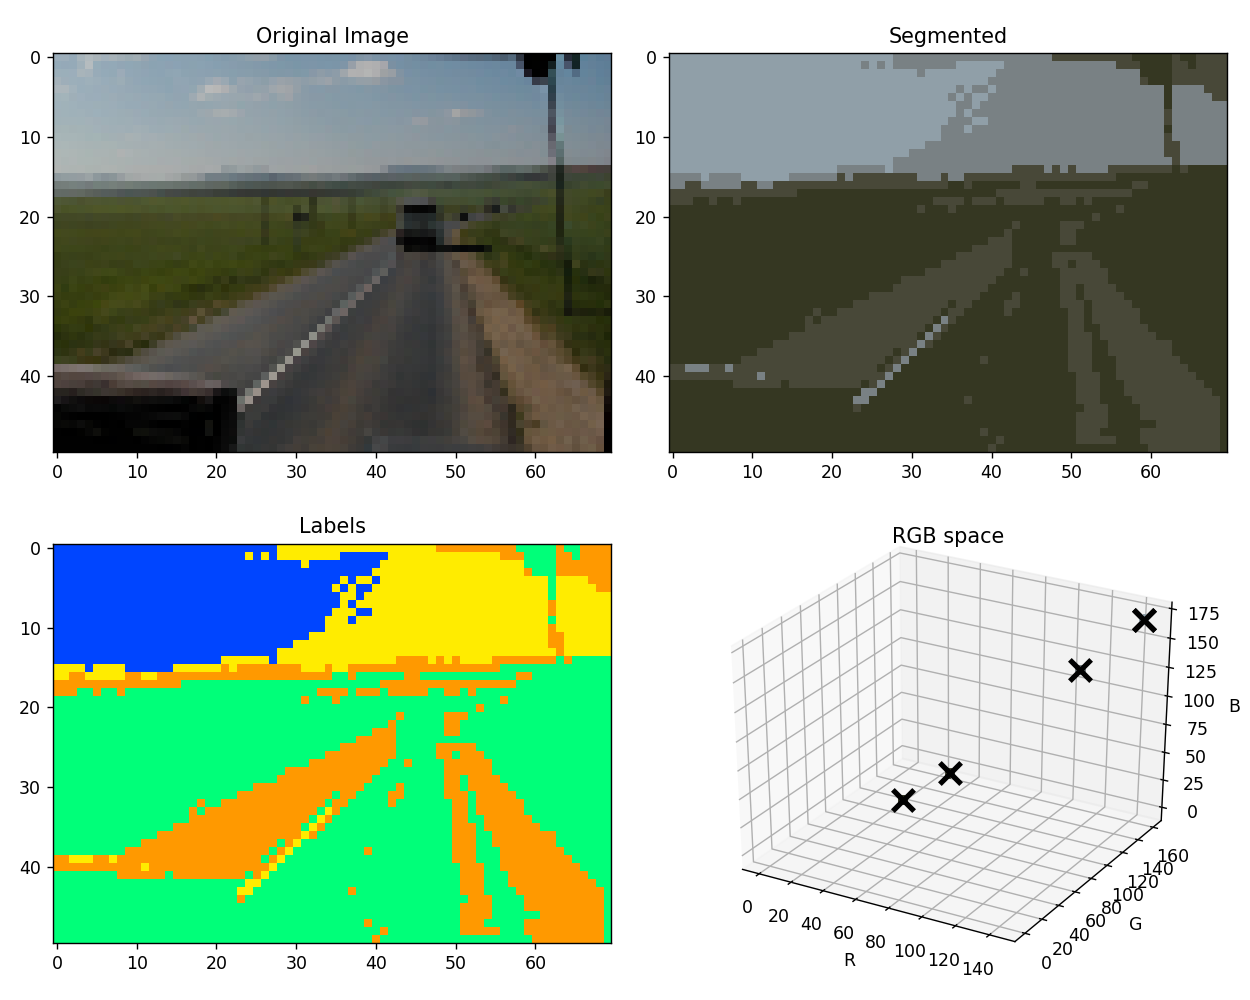

In [14]:
def make_label_colormap():
    """Create a color map for visualizing the labels themselves,
    such that the segment boundaries become more visible, unlike
    in the visualization using the cluster peak colors.
    """
    import matplotlib.colors
    rng = np.random.RandomState(2)
    values = np.linspace(0, 1, 20)
    colors = plt.cm.get_cmap('hsv')(values)
    rng.shuffle(colors)
    return matplotlib.colors.ListedColormap(colors)

label_cmap = make_label_colormap()

im = imageio.imread('terrain_small.png')
start_time = time.time()
data, peaks, labels, segmented_im = mean_shift_segment(im, radius=15)
duration= time.time()-start_time
print(f'Took {duration:.2f} s')

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(2, 2, 1)
ax.set_title('Original Image')
ax.imshow(im)

ax = fig.add_subplot(2, 2, 2)
ax.set_title('Segmented')
ax.imshow(segmented_im)

ax = fig.add_subplot(2, 2, 3)
ax.set_title('Labels')
ax.imshow(labels.reshape(im.shape[:2]), cmap=label_cmap)

ax = fig.add_subplot(2, 2, 4, projection='3d')
ax.set_title(f'RGB space')
plot_3d_clusters(ax, data, labels, peaks, colors='rgb', axis_names='RGB')
fig.tight_layout()

## Segmentation in LUV color space
Note that Mean-Shift uses the Euclidean distance metric. Unfortunately, the Euclidean distance in RGB color space does not correlate well to perceived difference in color by people. For example, in the green portion of RGB space, large distances are perceived as the same color, whereas in the blue part a small RGB-distance may represent a large change in perceived color. For this reason you should use the non-linear LUV color space. In this space Euclidean distance better models the perceived difference in color.

In the function `mean_shift_segment_luv(...)` cluster the image data in LUV color space by first converting the RGB color vectors to LUV using OpenCV: `cv2.cvtColor(rgb_image, cv2.COLOR_RGB2LUV)`. Then convert the resulting cluster centers back to RGB using `cv2.cvtColor(luv_image, cv2.COLOR_LUV2RGB)`.

If we want to include spatial *position information* in the feature vectors as well, we can make the feature vectors 5 dimensional by specifying the LUV values as well as the x,y coordinates of each pixel. Write a function `mean_shift_segment_luv_pos(im, radius)` that does this. **Hint:** useful functions are `np.arange`, `np.meshgrid`, `np.concatenate`, `np.expand_dims`).

In [15]:
def mean_shift_segment_luv(im, radius):
    # YOUR CODE HERE
    im_w, im_h, _ = im.shape
    data = cv2.cvtColor(im, cv2.COLOR_RGB2LUV)
    data, peaks, labels, segmented_im = mean_shift_segment(data, radius)
    # data = data.reshape(im_w, im_h, 3).astype("uint8")
    segmented_im = cv2.cvtColor(segmented_im, cv2.COLOR_LUV2LRGB)
    return data, peaks, labels, segmented_im
    
def mean_shift_segment_luv_pos(im, radius, pos_factor=1):
    # YOUR CODE HERE
    raise NotImplementedError()
    return data, peaks, labels, segmented_im

In [16]:
im = imageio.imread('terrain_small.png')
data, peaks, labels, segmented_im = mean_shift_segment_luv(im, radius=10)
fig = plt.figure(figsize=(12,8))

ax = fig.add_subplot(2, 3, 1)
ax.set_title('Segmented (LUV)')
ax.imshow(segmented_im)

ax = fig.add_subplot(2, 3, 2)
ax.set_title('Labels (LUV)')
ax.imshow(labels.reshape(im.shape[:2]), cmap=label_cmap)

ax = fig.add_subplot(2, 3, 3, projection='3d')
ax.set_title(f'LUV space')
plot_3d_clusters(ax, data, labels, peaks, colors='luv', axis_names='LUV')

data, peaks, labels, segmented_im = mean_shift_segment_luv_pos(im, radius=20)
ax = fig.add_subplot(2, 3, 4)
ax.set_title('Segmented (LUV+pos)')
ax.imshow(segmented_im)

ax = fig.add_subplot(2, 3, 5)
ax.set_title('Labels (LUV+pos)')
ax.imshow(labels.reshape(im.shape[:2]), cmap=label_cmap)

ax = fig.add_subplot(2, 3, 6, projection='3d')
ax.set_title(f'VXY space')
plot_3d_clusters(
    ax, data[:, 2:], labels, peaks[:, 2:], 
    peak_colors=peaks[:, :3], colors='luv', axis_names='VXY')
ax.invert_zaxis()
ax.view_init(azim=20, elev=15)

fig.tight_layout()

<IPython.core.display.Javascript object>

NotImplementedError: 

## Experiment with the parameters

How does the `radius` and the *feature vector* affect the resulting segmentations? What effect does adding position information have? What are the advantages and disadvantages of using each type of feature vector? Can you suggest any extensions that might avoid many of the situations where single regions are over-segmented into multiple regions?

YOUR ANSWER HERE

In [ ]:
radii = [5, 10, 20]
fig, axes = plt.subplots(len(radii), 3, figsize=(15, 15))
for radius, ax in zip(radii, axes):
    segmented_im = mean_shift_segment(im, radius)[-1]
    ax[0].imshow(segmented_im)
    ax[0].set_title(f'Radius {radius} RGB')
    
    segmented_im = mean_shift_segment_luv(im, radius)[-1]
    ax[1].imshow(segmented_im)
    ax[1].set_title(f'Radius {radius} LUV')

    segmented_im = mean_shift_segment_luv_pos(im, radius)[-1]
    ax[2].imshow(segmented_im)
    ax[2].set_title(f'Radius {radius} LUV+pos')
fig.tight_layout()

## [BONUS] Test it on a larger image

Run your algorithm on at least one larger (approx. 300x200) test image using your own choice of `radius` and feature vector definition. One source for possible test images is the dataset of images available at http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/segbench/. You can also try the example images included in the scikit-image library, e.g. `import skimage.data; im = skimage.data.astronaut()`. Or any image from anywhere.

Processing can take several minutes for larger images.

In [ ]:
import skimage.data
im = skimage.data.astronaut()
im = cv2.resize(im, (256,256))

# YOUR CODE HERE
raise NotImplementedError()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].set_title('Original image')
axes[0].imshow(im)
axes[1].set_title('Segmented image')
axes[1].imshow(segmented_im)
axes[2].set_title('Labels')
axes[2].imshow(labels.reshape(im.shape[:2]), cmap=label_cmap)
fig.tight_layout()

## [BONUS++] Efficient Implementation

Mean-shift is highly parallelizable and GPU-based implementations can be many times faster for such workloads.
If you already know TensorFlow or CUDA, you can try implementing mean-shift for the GPU.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()